# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

## Data pre-processing

In [2]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

### Sorting labels

In [3]:
df_train_labels = df_train_labels.sort_values('pid')
df_train_features = df_train_features.sort_values(['pid', 'Time'])

# Droping time
df_train_features = df_train_features.drop('Time', axis = 1)
df_test_features = df_test_features.drop('Time', axis = 1)

 ### Histogram of the output labels 

We should check for class imbalance.

In [ ]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Boxplot over features

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

In [ ]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

In [ ]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [9]:
# Which columns have less than a percent NA
NA_percent = 0.7
NA_percent_severe = 0.91

sel_features = df_train_features.isnull().sum(axis=0) < (NA_percent * df_train_features.shape[0])
inds = np.where(sel_features == True)

sel_features_2 = (df_train_features.isnull().sum(axis=0) < (NA_percent_severe * df_train_features.shape[0])) & (df_train_features.isnull().sum(axis=0) > (NA_percent * df_train_features.shape[0]))        
inds_2 = np.where(sel_features_2 == True)

sel_features_3 = df_train_features.isnull().sum(axis=0) > (NA_percent_severe * df_train_features.shape[0])
inds_3 = np.where(sel_features_3 == True)

print(inds[0])
print(inds_2[0])
print(inds_3[0])
vars_class1 = df_train_features.columns[inds[0]]
vars_class2 = df_train_features.columns[inds_2[0]]
vars_class3 = df_train_features.columns[inds_3[0]]
vars_classes = [vars_class1, vars_class2, vars_class3]

df_train_features.columns.drop("pid")

[ 0  1  6 10 21 24 27 31 34]
[ 7 15 17 20 23 30 35]
[ 2  3  4  5  8  9 11 12 13 14 16 18 19 22 25 26 28 29 32 33]


Index(['Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine',
       'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm',
       'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2',
       'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total',
       'TroponinI', 'ABPs', 'pH'],
      dtype='object')

In [22]:
def aggregation_technique(dat, variables, pids, vars_classes):
    
    vars_class1 = vars_classes[0]
    vars_class2 = vars_classes[1]
    vars_class3 = vars_classes[2]
    
    aggregated_dataframe = []
    for pid in pids:
        # dataframe for this pid
        df = dat.loc[dat['pid'] == pid]
        calculated_features = []
        for var in variables:
            # how many NaN are in there for this variable
            data = df[var].tolist()
#             num_nan = np.count_nonzero(np.isnan(data))
            if var == "Age":
                calculated_features.append(data[0])
                
            elif var in vars_class1:
                calculated_features = calculated_features + data
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
                
            elif var in vars_class2:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(np.nanmin(data))
                calculated_features.append(np.nanmax(data))
            else:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                
        aggregated_dataframe.append(calculated_features)
        
    aggregated_dataframe = pd.DataFrame(aggregated_dataframe)
    return(aggregated_dataframe)
 
train_pids = df_train_features['pid'].unique()
df_train_agg_features = aggregation_technique(df_train_features, df_train_features.columns.drop("pid"), train_pids, vars_classes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN axis encountered


In [31]:
print(df_train_agg_features.shape)
print(df_train_agg_features.columns)
print(df_train_agg_features)
pd.DataFrame(data_train_scaled)

(18995, 153)
RangeIndex(start=0, stop=153, step=1)
        0    1    2     3    4     5    6    7    8     9    ...    143  \
0      34.0  NaN  NaN   NaN  NaN  12.0  0.0  NaN  NaN  36.0  ...  112.0   
1      86.0  NaN  NaN  31.8  0.0  32.0  0.0  NaN  NaN   NaN  ...  138.0   
2      66.0  NaN  NaN  34.6  0.0   8.0  0.0  NaN  NaN   NaN  ...  130.0   
3      66.0  NaN  NaN  53.8  0.0  32.0  0.0  1.8  0.0  35.0  ...  100.0   
4      42.0  NaN  NaN   NaN  NaN  18.0  0.0  NaN  NaN   NaN  ...  229.0   
...     ...  ...  ...   ...  ...   ...  ...  ...  ...   ...  ...    ...   
18990  52.0  NaN  NaN  25.8  0.0  11.0  0.0  1.7  0.4   NaN  ...    NaN   
18991  66.0  NaN  NaN   NaN  NaN  33.0  1.0  NaN  NaN   NaN  ...  176.0   
18992  44.0  NaN  NaN   NaN  NaN  15.0  0.0  NaN  NaN   NaN  ...   88.0   
18993  70.0  NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...  106.0   
18994  60.0  NaN  NaN   NaN  NaN  13.0  0.0  NaN  NaN   NaN  ...  127.0   

         144    145    146    147    148       1

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,-1.706426,-0.224846,0.680147,-0.321247,-0.369360,-0.633815,-0.289991,0.258722,-0.248780,-1.076135,...,-0.449958,-0.029881,-0.163171,-0.526297,0.107303,-0.886874,-0.296017,0.671270,-0.561881,0.132128
1,1.454319,-0.362119,-0.329377,-0.466488,-0.388697,0.502558,-0.289991,-0.404296,-0.396766,-0.034769,...,0.723244,0.471472,0.156173,0.339289,0.198069,0.650949,-0.043909,-0.604821,0.220791,-0.281705
2,0.238648,-0.513048,1.099007,-0.298440,-0.388697,-0.861090,-0.289991,-0.502985,-0.258846,0.173504,...,0.362259,-0.257768,-1.075583,-1.619669,-1.435709,-1.158255,0.691063,0.091345,0.481682,0.785547
3,0.238648,-0.273910,-0.380159,0.853882,-0.388697,0.502558,-0.289991,-0.207302,-0.618837,-3.158867,...,-0.991435,-1.078163,-0.528136,-1.255212,-0.618820,-1.067794,-0.666462,0.134291,-0.561881,-0.303485
4,-1.220158,-0.467936,-0.757716,-0.051471,-0.051181,-0.292903,-0.289991,-0.120429,0.292490,-0.451315,...,4.829448,3.114966,2.574063,2.799377,3.964835,3.726596,0.244214,-0.290902,0.238184,0.110347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18990,-0.612322,0.904458,0.121798,-0.826588,-0.388697,-0.690634,-0.289991,-0.303241,0.647618,-0.659588,...,-1.397543,-1.670670,-1.258065,-1.150430,-1.526475,-1.212531,-1.160388,-0.975176,-0.561881,-1.610324
18991,0.238648,-0.730157,-0.882258,-0.200913,0.654508,0.559377,0.656830,-0.305639,0.446677,-0.243042,...,2.437922,2.978233,2.437201,1.569333,1.604933,1.419861,0.360904,0.021058,0.220791,0.349934
18992,-1.098590,0.617296,0.462757,-0.151399,-0.388697,-0.463359,-0.289991,0.024871,-0.574061,1.006597,...,-1.532913,-0.075458,-1.394927,-1.300769,-0.800351,-0.579309,-1.808666,1.163620,-1.953299,-1.392518
18993,0.481782,-0.172867,0.090014,-0.033016,1.134539,0.707105,-0.005945,-0.713859,-0.083698,-0.867862,...,-0.720696,-0.608715,-0.938721,-0.571854,-0.573438,-0.705954,0.918346,0.011515,0.586038,0.807327


In [13]:
# # Run the imputer with a simple Random Forest estimator
# imp = IterativeImputer(RandomForestRegressor(n_estimators=5), max_iter=10, random_state=1)

# #perform filling
# df_train_agg_imputed_features = pd.DataFrame(imp.fit_transform(df_train_agg_features), columns=df_train_agg_features.columns)

In [25]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)

df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)

In [26]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

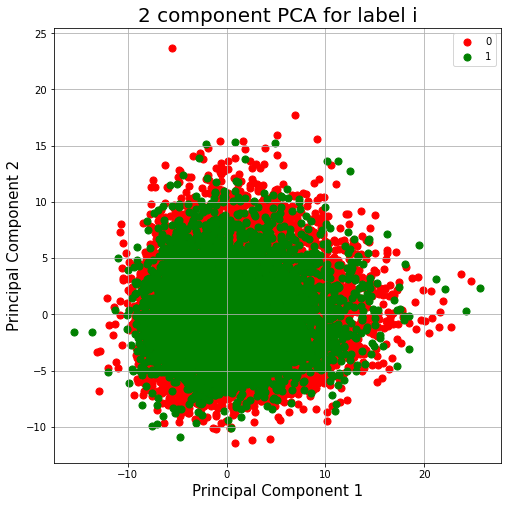

In [28]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[[df_train_labels.columns[1]]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for label i', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[df_train_labels.columns[1]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [23]:
test_pids = df_test_features['pid'].unique()
df_test_agg_features = aggregation_technique(df_test_features, df_test_features.columns.drop("pid"),
                                             test_pids, vars_classes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN axis encountered


In [32]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors= 10)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [33]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [34]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_scaled.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_scaled.csv", index = False)

In [ ]:
# # If want to run from here:
# data_train_scaled = pd.read_csv("./Results/dat_train_scaled.csv")
# data_test_scaled = pd.read_csv("./Results/dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [ ]:
# first for the labels that have an output [0,1]
test_pids = list(set(df_test_features.pid))
columns_1 = [test_pids]

from sklearn.utils import resample

for i in range(1, 12):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=40)
    train_features = pd.DataFrame(transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i]))
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = pd.DataFrame(transformer.transform(data_test_scaled))

#     values_1 = train_features.loc[df_train_labels[df_train_labels.columns[i]] == 1]
#     values_0 = train_features.loc[df_train_labels[df_train_labels.columns[i]] == 0]
#     values_0 = resample(values_0, replace = False, n_samples = values_1.shape[0])

#     train_features = pd.concat([values_0, values_1])
    
#     labels = np.repeat([0,1], values_0.shape[0])
    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf_w = SVC(kernel = 'rbf', class_weight = 'balanced', verbose = 2)
    
    parameters = {'C':(0.1, 1, 5, 10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                        refit = True, scoring = 'roc_auc', verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
#     clf.fit(train_features, labels)
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [ ]:
# labels that have a real value
columns_2 = []
# from sklearn.kernel_ridge import KernelRidge

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 80)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = SVR(kernel = 'rbf', cache_size = 6000)
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
    parameters = {'C':(0.1, 1,10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

In [ ]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [ ]:
#labels that have a real value

columns_2 = []

for i in range(12, 16):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(list(data_train_scaled)[transformer.get_support()])
    test_features = transformer.transform(data_test_scaled)
    

    clf_w = LinearSVR()
    parameters = {'C':(0.01, 0.1,1,10,30,50, 75,100)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:   34.1s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:   56.1s finished


{'C': 0.1}
0.42324730075182815
R2 for feature LABEL_RRate  :  0.4262879378515111
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:   49.6s finished


{'C': 1}
0.6095531130900383
R2 for feature LABEL_ABPm  :  0.6120926319749987


In [ ]:
transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,11])
test_features = transformer.transform(data_test_scaled)

In [ ]:
df_train_agg_features.columns[transformer.get_support(indices = True)]

In [ ]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

# Kernelized Logistic Regression

In [35]:
# first for the labels that have an output [0,1]
test_pids = list(set(df_test_features.pid))
columns_1 = [test_pids]

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import StratifiedKFold, KFold

for i in range(1, 12):
    
    #     feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param = 30)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
   
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)
    
    clf_w = LogisticRegression(penalty = 'l2', class_weight = 'balanced', max_iter=10000)
    
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'C':(0.1, 1, 5, 10, 20)}
    
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
 
    probability_tmp = clf.predict_proba(test_transformed)
    probability = [item[1] for item in probability_tmp]
    columns_1.append(probability)

    probability_tmp = clf.predict_proba(train_transformed)
    probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   21.8s finished


[0.81878265 0.84445245 0.85260294 0.85413933 0.85498847]
[0.81570328 0.83824582 0.84403568 0.84482553 0.84512344]
{'C': 20}
0.8451234357006211
ROC AUC for feature LABEL_BaseExcess  :  0.8545741886719656
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   16.4s finished


[0.74696328 0.77253287 0.78154588 0.78309119 0.78380345]
[0.73293454 0.74095262 0.73784958 0.73581019 0.73405216]
{'C': 1}
0.7409526161374158
ROC AUC for feature LABEL_Fibrinogen  :  0.7713446596029716
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   19.9s finished


[0.67688102 0.69247357 0.6978149  0.69854844 0.69885508]
[0.66972212 0.67626164 0.67553481 0.67481352 0.67414966]
{'C': 1}
0.6762616423976096
ROC AUC for feature LABEL_AST  :  0.6919628174027634
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   18.8s finished


[0.68170435 0.699611   0.70573316 0.70657719 0.70690913]
[0.67533373 0.68550246 0.68644176 0.68577987 0.68518204]
{'C': 5}
0.6864417594769151
ROC AUC for feature LABEL_Alkalinephos  :  0.7048186842988312
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   20.1s finished


[0.68112123 0.6976447  0.70413987 0.7051684  0.70561784]
[0.67432133 0.68240322 0.68353353 0.68324508 0.68291063]
{'C': 5}
0.6835335339074372
ROC AUC for feature LABEL_Bilirubin_total  :  0.7031862535031799
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   19.4s finished


[0.74104143 0.75548914 0.76042597 0.7612016  0.76154153]
[0.73578395 0.7431561  0.74285367 0.74207374 0.74144727]
{'C': 1}
0.7431561010754377
ROC AUC for feature LABEL_Lactate  :  0.7551540820922813
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   19.9s finished


[0.71238658 0.74093032 0.74961844 0.75116075 0.75190056]
[0.70004694 0.71796763 0.71947643 0.71901203 0.71842768]
{'C': 5}
0.7194764290518368
ROC AUC for feature LABEL_TroponinI  :  0.7482680800506103
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   17.7s finished


[0.76396387 0.78041847 0.78574241 0.78653123 0.78689735]
[0.75990782 0.77015166 0.77123136 0.77073083 0.77028835]
{'C': 5}
0.7712313641404844
ROC AUC for feature LABEL_SaO2  :  0.7850150595650323
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   22.7s finished


[0.73617996 0.77368117 0.7893892  0.79259697 0.79440226]
[0.70710479 0.71369461 0.70945262 0.70748964 0.70575749]
{'C': 1}
0.713694605069024
ROC AUC for feature LABEL_Bilirubin_direct  :  0.7713611914120475
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   21.3s finished


[0.8032591  0.83894131 0.85248844 0.85480467 0.85592281]
[0.79250364 0.81721612 0.82322558 0.82311404 0.82256887]
{'C': 5}
0.8232255816809918
ROC AUC for feature LABEL_EtCO2  :  0.851301830422452
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   16.4s finished


[0.69661242 0.72079296 0.730085   0.73178992 0.73266079]
[0.67501357 0.67544378 0.66854558 0.66602644 0.66417271]
{'C': 1}
0.6754437844430262
ROC AUC for feature LABEL_Sepsis  :  0.718831199760856


# Compute the kernel and use SGD Classifier and Regressor

In [ ]:
# first for the labels that have an output [0,1]
test_pids = list(set(df_test_features.pid))
columns_1 = [test_pids]

# from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import Nystroem
from sklearn import linear_model


for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=70)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    
    feature_map_nystroem = Nystroem(kernel = 'poly', degree = 3,
                                 random_state=1,
                                 n_components=300)
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDClassifier(max_iter=100000, tol=1e-4, penalty = "l2", 
                                       loss = "epsilon_insensitive", class_weight='balanced')
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'alpha':(0.1, 1, 5, 10)}
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_transformed)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_transformed)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

In [37]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
#     feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    train_features = feature_map_nystroem.fit_transform(train_features)
    test_features = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDRegressor(max_iter=100000, tol=1e-4,
                                     loss = 'epsilon_insensitive', penalty = 'l2')
    parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6, return_train_score=True)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred) 

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   13.3s finished


[ 0.35964108  0.33981325  0.24166369  0.05053342 -0.00351423 -0.01027274
 -0.01090288]
[ 0.35667887  0.33792944  0.24090779  0.04998178 -0.00407271 -0.01082901
 -0.01153702]
{'alpha': 0.0001}
0.3566788690583337
R2 for feature LABEL_RRate  :  0.3609862457997741
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   45.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   47.9s finished


[ 0.55246603  0.51007525  0.32544404  0.05517278 -0.00605924 -0.0121471
 -0.01290328]
[ 0.5500808   0.50891718  0.32508086  0.0547322  -0.00652034 -0.01260514
 -0.01335925]
{'alpha': 0.0001}
0.5500807970072753
R2 for feature LABEL_ABPm  :  0.5537106271451131
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   15.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   16.5s finished


[ 0.26899318  0.26192546  0.22114906  0.07310877  0.00224452 -0.00367196
 -0.00462038]
[ 0.27463505  0.26875284  0.22893908  0.07594985  0.00219924 -0.00387914
 -0.00479747]
{'alpha': 0.0001}
0.2746350536732448
R2 for feature LABEL_SpO2  :  0.26921100304669854
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   51.9s


KeyboardInterrupt: 

In [ ]:
columns_final = columns_1 + columns_2

# XGBoosting

The benefit of XGBoost is that it accepts missing values.

In [18]:
import xgboost as xgb
# simple example
# load file from text file, also binary buffer generated by xgboost

# scale test data
min_max_scaler = preprocessing.StandardScaler()
df_train_agg_features = min_max_scaler.fit_transform(df_train_agg_features)
min_max_scaler = preprocessing.StandardScaler()
df_test_agg_features = min_max_scaler.fit_transform(df_test_agg_features)

dtrain = xgb.DMatrix(df_train_agg_features, label=df_train_labels.iloc[:,11])
dtest = xgb.DMatrix(df_test_agg_features)

In [19]:
param = {'eta': 1, 'objective': 'binary:logistic', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train')]

In [21]:
num_round = 10
xgb.cv(param, dtrain, num_round, nfold=10,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# bst = xgb.train(param, dtrain, num_round)
# pred = bst.predict(dtest)

[0]	train-auc:0.69259+0.00842	test-auc:0.65440+0.03319
[1]	train-auc:0.77342+0.00552	test-auc:0.67344+0.03340
[2]	train-auc:0.82367+0.00539	test-auc:0.67924+0.03416
[3]	train-auc:0.86180+0.00672	test-auc:0.66367+0.02651
[4]	train-auc:0.88661+0.00668	test-auc:0.65502+0.02548
[5]	train-auc:0.90325+0.00657	test-auc:0.65116+0.02622
[6]	train-auc:0.91790+0.00766	test-auc:0.65072+0.02721
[7]	train-auc:0.93087+0.00623	test-auc:0.65247+0.02557
[8]	train-auc:0.94280+0.00519	test-auc:0.65207+0.02668
[9]	train-auc:0.95150+0.00444	test-auc:0.65035+0.02617


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.692593,0.008420,0.654405,0.033193
1,0.773418,0.005520,0.673440,0.033402
2,0.823671,0.005385,0.679241,0.034158
3,0.861801,0.006719,0.663670,0.026510
4,0.886607,0.006679,0.655022,0.025481
5,0.903248,0.006569,0.651164,0.026220
6,0.917900,0.007659,0.650715,0.027210
7,0.930865,0.006231,0.652475,0.025569
8,0.942800,0.005190,0.652069,0.026679
9,0.951503,0.004442,0.650346,0.026169


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.kernel_approximation import Nystroem

test_pids = list(set(df_test_features.pid))
columns_1 = [test_pids]


for i in range(1,12):

    clf = xgb.XGBClassifier('binary:logistic')
    
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
    clf_w = model_selection.GridSearchCV(estimator= clf, param_grid = {'max_depth': [2,4,6,8,10]}, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    

    clf_w.fit(train_features, df_train_labels.iloc[:,i])
    
#     dtrain = xgb.DMatrix(df_train_agg_features, label=df_train_labels.iloc[:,i])
#     num_round = 10
#     xgb.cv(param, dtrain, num_round, nfold=10,
#        metrics={'auc'}, seed=0,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
    
    probability = clf_w.predict(test_features)
    columns_1.append(probability)

    probability_train = clf_w.predict(train_features)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

In [44]:
columns_2 = []
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
evallist = [(dtrain, 'train')]

for i in range(12,16):

    clf_w = xgb.XGBRegressor(feval = r2_score, verbosity = 0)
        
    clf_w.fit(df_train_agg_features, df_train_labels.iloc[:,i])
    
    dtrain = xgb.DMatrix(df_train_agg_features, label=df_train_labels.iloc[:,i])
    num_round = 10
    
    probability = clf_w.predict(df_test_agg_features)
    columns_1.append(probability)

    pred_train = clf_w.predict(df_train_agg_features)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

R2 for feature LABEL_RRate  :  0.8089942330324328
R2 for feature LABEL_ABPm  :  0.869859539379728
R2 for feature LABEL_SpO2  :  0.8214481534384943
R2 for feature LABEL_Heartrate  :  0.8746805066302505


In [ ]:
columns_final = columns_1 + columns_2

## Save predictions

In [ ]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')